## 练习：分类花朵图像
使用本节课所学内容建立一个带有防止过拟合方法的CNN模型
### 样例
尺寸不同的RGB三通道彩色图片，总共五种类型的花的图片
### 标签
* 0: daisy
* 1: dandelion
* 2: roses
* 3: sunflowers
* 4: tulips

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

In [2]:
#import packages
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 导入数据
### 下载数据
首先将花朵数据下载到本地，并解压到同文件夹中data路径下。[数据下载链接](https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz)。解压后的文件目录结构为：
<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>diasy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
</pre>

之后需要对文件夹中的图片数据进行划分，分成训练集和验证集，其中80%为训练集。使用下面代码对数据进行自动处理，处理后的文件目录结构为：
<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>diasy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
|__ <b>train</b>
    |______ <b>daisy</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>dandelion</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>roses</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>sunflowers</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>tulips</b>: [1.jpg, 2.jpg, 3.jpg ....]
 |__ <b>val</b>
    |______ <b>daisy</b>: [507.jpg, 508.jpg, 509.jpg ....]
    |______ <b>dandelion</b>: [719.jpg, 720.jpg, 721.jpg ....]
    |______ <b>roses</b>: [514.jpg, 515.jpg, 516.jpg ....]
    |______ <b>sunflowers</b>: [560.jpg, 561.jpg, 562.jpg .....]
    |______ <b>tulips</b>: [640.jpg, 641.jpg, 642.jpg ....]   
</pre>

In [3]:
base_dir = os.path.join('data', 'flower_photos')

classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

# for cl in classes:
#     # 对于每一类的图片文件夹
#     img_path = os.path.join(base_dir, cl)
#     # 使用glob.glob()方法获取当前文件夹下匹配参数字符串的所有文件名
#     images = glob.glob(img_path + '/*.jpg')
#     print("{}: {} Images".format(cl, len(images)))
#     train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]
    
#     # 建立对应的训练集和验证集文件目录
#     if not os.path.exists(os.path.join(base_dir, 'train', cl)):
#         os.makedirs(os.path.join(base_dir, 'train', cl))
#     if not os.path.exists(os.path.join(base_dir, 'val', cl)):
#         os.makedirs(os.path.join(base_dir, 'val', cl))
        
#     # 使用shutil.move()方法移动文件
#     for t in train:
#         shutil.move(t, os.path.join(base_dir, 'train', cl))

#     for v in val:
#         shutil.move(v, os.path.join(base_dir, 'val', cl))

In [4]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

### 设置BATCH_SIZE以及IMG_SHAPE
* **BATCH_SIZE**：一个Batch中图片的数量
* **IMG_SHAPE**：首先需要将尺寸不同的图片处理成尺寸相同的图片，这里的``IMG_SHAPE``即处理后的图片高和宽的像素数

In [5]:
BATCH_SIZE = 128
IMG_SHAPE = 224

## 数据增强操作

In [6]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

Found 2935 images belonging to 5 classes.


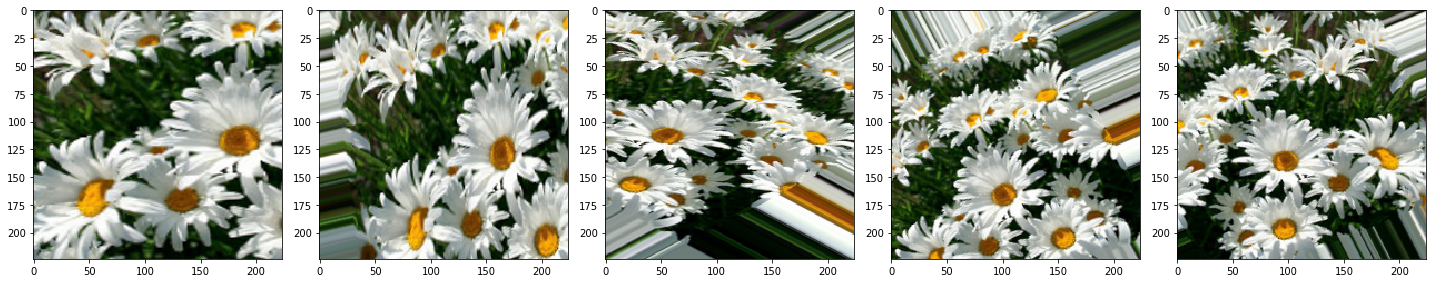

In [7]:
image_gen = ImageDataGenerator(rescale=1./255,
                              rotation_range=45,
                              zoom_range=.5,
                              horizontal_flip=True,
                              width_shift_range=.15,
                              height_shift_range=.15)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                              directory=train_dir,
                                              shuffle=True,
                                              target_size=(IMG_SHAPE, IMG_SHAPE),
                                              class_mode='sparse')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [8]:
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                directory=val_dir,
                                                shuffle=False,
                                                target_size=(IMG_SHAPE, IMG_SHAPE),
                                                class_mode='sparse')
# image_gen_val = ImageDataGenerator(rescale=1./255)
# val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
#                                                 directory=train_dir,
#                                                 shuffle=False,
#                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
#                                                 class_mode='sparse')

Found 735 images belonging to 5 classes.


## 构建模型

In [9]:
class MobileNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.Conv_32 = Conv2D(32, (3,3), padding='same', strides=2, activation='linear')
        self.Conv_64 = Conv2D(64, (3,3), padding='same', strides=1, activation='linear')
        self.Conv_128 = Conv2D(128, (3,3), padding='same', strides=1, activation='linear')
        self.Conv_256 = Conv2D(256, (3,3), padding='same', strides=1, activation='linear')
        self.Conv_512 = Conv2D(512, (3,3), padding='same', strides=1, activation='linear')
        self.Conv_1024 = Conv2D(1024, (3,3), padding='same', strides=1, activation='linear')
        self.DepthConv_1 = DepthwiseConv2D(kernel_size=(3,3), strides=1, padding='same', activation='linear', depth_multiplier=1,
                                           depthwise_regularizer='l2', bias_regularizer='l2')
        self.DepthConv_2 = DepthwiseConv2D(kernel_size=(3,3), strides=2, padding='same', activation='linear', depth_multiplier=1,
                                           depthwise_regularizer='l2', bias_regularizer='l2')
        
        self.relu = ReLU()
        self.BN = BatchNormalization()
        self.flatten = Flatten()
        self.pool = GlobalAveragePooling2D()
        self.Dense = Dense(units=5, activation='softmax')
        
    def call(self, inputs, training=True):
        h = self.Conv_32(inputs)
        h = self.BN(h, training=training)
        h = self.relu(h)
        
        h = self.DepthConv_1(h)
        h = self.BN(h, training=training)
        h = self.relu(h)
        h = self.Conv_64(h)
        h = self.BN(h, training=training)
        h = self.relu(h)
                
        h = self.DepthConv_2(h)
        h = self.BN(h, training=training)
        h = self.relu(h)
        h = self.Conv_128(h)
        h = self.BN(h, training=training)
        h = self.relu(h)
                
        h = self.DepthConv_1(h)
        h = self.BN(h, training=training)
        h = self.relu(h)
        h = self.Conv_128(h)
        h = self.BN(h, training=training)
        h = self.relu(h)
                
        h = self.DepthConv_2(h)
        h = self.BN(h, training=training)
        h = self.relu(h)
        h = self.Conv_256(h)
        h = self.BN(h, training=training)
        h = self.relu(h)
                
        h = self.DepthConv_1(h)
        h = self.BN(h, training=training)
        h = self.relu(h)
        h = self.Conv_256(h)
        h = self.BN(h, training=training)
        h = self.relu(h)
                
        h = self.DepthConv_2(h)
        h = self.BN(h, training=training)
        h = self.relu(h)
        h = self.Conv_512(h)
        h = self.BN(h, training=training)
        h = self.relu(h)
        
        for i in range(5):
            h = self.DepthConv_1(h)
            h = self.BN(h, training=training)
            h = self.relu(h)
            h = self.Conv_512(h)
            h = self.BN(h, training=training)
            h = self.relu(h)
        
        for i in range(2):
            h = self.DepthConv_2(h)
            h = self.BN(h, training=training)
            h = self.relu(h)
            h = self.Conv_1024(h)
            h = self.BN(h, training=training)
            h = self.relu(h)
            
        h = self.pool(h)
        h = self.flatten(h)
        h = self.Dense(h)
        return h

In [10]:
model = MobileNet()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
# for i in range(10):
for batch_index in range(train_data_gen.n // BATCH_SIZE + 1):
    with tf.GradientTape() as tape:
        y_pred = model(train_data_gen[batch_index][0], training=True)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=train_data_gen[batch_index][1], y_pred=y_pred)
        loss = tf.reduce_mean(loss)
        print("batch {}: loss {}".format(batch_index, loss.numpy()))
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))

In [19]:
train_data_gen.n / BATCH_SIZE

22.9296875